<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/11_3_testBreast_Cancer_IDC_Prediction_Using_CNN_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# CNN - ML pipeline

  1) EDA and Image Visualization<br>
  2) Randomly sample from training/test/validation = 800/ 200/ 200 (66%/ 17%/ 17%)<br>
  3) Image Transformations<br>
> Image resize<br>
> Image normalization to [0, 1]<br>
  
  4) [Image Augmentations](https://iq.opengenus.org/data-augmentation/)<br>
> Adjust brightness<br>
> Adjust contrast<br>
> Flip left and right<br>
> Rotate 90 degrees<br>

 5) CNN Model using Tensorflow Keras API<br>
> Build model<br>
> Compile model<br>
> Fit model<br>

 6) Evaluate the Model<br>
 : Determine how good our trained model applies in predicting unseen (test) data.
> model.**evaluate**<br>
> model.**predict**<br>
> Evaluation Metrics:  True Labels VS. Predicted Labels<br>

 7) Hyper Parameter Tuning<br>
> Optimizer<br>
> Learning Rate<br>
> Dropout ratio<br>
> Number of Epochs<br>
> Contrast Factor<br>
> Delta<br>









In [2]:
%pwd

'/content'

In [3]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [4]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
    # idc_image_label.append(str(split_path[8]))
  return idc_image_path, idc_image_label, directory_name

In [5]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [6]:
print(train_labels[:5])
print(train_labels[-5:])

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

['class_0', 'class_0', 'class_0', 'class_0', 'class_0']
['class_1', 'class_1', 'class_1', 'class_1', 'class_1']
800 800
200 200
200 200


In [7]:
print(train_paths[:2])
print(train_labels[:10])
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png']
['class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0']
Train


In [8]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [9]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print('type(train_dataframe): ',type(train_dataframe))
train_dataframe

                                                  path    label
227  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
193  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
169  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
567  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
398  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
..                                                 ...      ...
358  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
94   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
31   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
751  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
560  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
type(train_dataframe):  <class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [10]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label
260  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
614  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
655  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
264  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
797  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
426  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
47   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
65   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
776  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
744  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
                                                  path    label
75   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
33   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
78   /content/gd

In [11]:
# train_generator

In [12]:
# https://faroit.com/keras-docs/0.3.3/preprocessing/image/
# data_generator = ImageDataGenerator(
#     featurewise_center = True,
#     featurewise_std_normalization = True,
#     #these are the augmentation features that you can adjust
#     # link to read more about them https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
#     zca_whitening=False,
#     zca_epsilon=1e-06,
#     rotation_range=0,
#     width_shift_range=0.0,
#     height_shift_range=0.0,
#     brightness_range=None,
#     shear_range=0.0,
#     zoom_range=0.0,
#     channel_shift_range=0.0,
#     fill_mode='nearest',
#     cval=0.0,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None,
# )

data_generator = ImageDataGenerator()

train_data_generator = data_generator.flow_from_dataframe(
    train_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    featurewise_center = True,                     # transforms the images to 0 mean
    featurewise_std_normalization = True,          # divide inputs by std of the dataset
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
    # seed=1234
    # validate_filenames=True
)

validation_data_generator = data_generator.flow_from_dataframe(
    val_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    featurewise_center = True,
    featurewise_std_normalization = True,
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
    # seed=1234
    # validate_filenames=True
)

test_data_generator = data_generator.flow_from_dataframe(
    test_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    featurewise_center = True,
    featurewise_std_normalization = True,
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False              # Kesha set to shuffle=True
    # seed=1234
    # validate_filenames=True
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [13]:
img_height = 50
img_width = 50
img_channel = 1

In [14]:
def get_doc_id_model():
  return tf.keras.Sequential([
                           keras.layers.Conv2D(input_shape = (img_height, img_width, img_channel), 
                                               filters=32, 
                                               kernel_size=(3, 3),
                                               padding='same', 
                                               activation='relu'),
                           
                           keras.layers.MaxPooling2D(pool_size=(2, 2),
                                                  strides=(2, 2)),
                           
                           keras.layers.Conv2D(filters=64, 
                                               kernel_size=(3, 3), 
                                               padding='same', 
                                               activation='relu'),
                              
                           keras.layers.MaxPooling2D(pool_size=(2, 2),
                                                  strides=(2, 2)),
                          
                           keras.layers.Conv2D(filters=128, 
                                               kernel_size=(3, 3), 
                                               padding='same', 
                                               activation='relu'),
                          
                           keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                                  strides=(2, 2)),
                           
                           keras.layers.Flatten(),
                           
                           keras.layers.Dense(units = 256, 
                                              activation = 'relu'),
                           
                          #  keras.layers.Dense(units = 512, 
                          #                     activation = 'relu'),
                           
                           keras.layers.Dense(units = 2, 
                                              activation = 'softmax')
])

In [15]:

from tensorflow import keras
model = get_doc_id_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), 
                    loss=keras.losses.categorical_crossentropy, 
                    metrics=['accuracy']
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [16]:
# tf.keras.callbacks.EarlyStopping => Stop training when a monitored metric has stopped improving.
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# This callback will stop the training when there is no improvement in the val_acc for 6 consecutive epochs
val_acc_early_stopping = EarlyStopping(monitor = 'val_acc', 
                                       patience = 6,        # Number of epochs with no improvement after which training will be stopped.
                                       verbose = 1,         # 1: displays messages when the callback takes an action
                                       mode = 'auto')

In [17]:
history = model.fit(train_data_generator,
                 epochs=7,
                #  callbacks=[val_acc_early_stopping],
                 validation_data = validation_data_generator
                 )
# len(history.history['val_accuracy'])

Epoch 1/7
25/25 [==============================] - 11s 402ms/step - loss: 10.9381 - accuracy: 0.5175 - val_loss: 0.6497 - val_accuracy: 0.6350
Epoch 2/7
25/25 [==============================] - 12s 481ms/step - loss: 0.6529 - accuracy: 0.6012 - val_loss: 0.6330 - val_accuracy: 0.6500
Epoch 3/7
25/25 [==============================] - 7s 288ms/step - loss: 0.5732 - accuracy: 0.7013 - val_loss: 0.6807 - val_accuracy: 0.5850
Epoch 4/7
25/25 [==============================] - 6s 226ms/step - loss: 0.5512 - accuracy: 0.7138 - val_loss: 0.5715 - val_accuracy: 0.7050
Epoch 5/7
25/25 [==============================] - 6s 227ms/step - loss: 0.5210 - accuracy: 0.7300 - val_loss: 0.6364 - val_accuracy: 0.6350
Epoch 6/7
25/25 [==============================] - 6s 229ms/step - loss: 0.5042 - accuracy: 0.7462 - val_loss: 0.5782 - val_accuracy: 0.7200
Epoch 7/7
25/25 [==============================] - 6s 229ms/step - loss: 0.4904 - accuracy: 0.7625 - val_loss: 0.5977 - val_accuracy: 0.7250


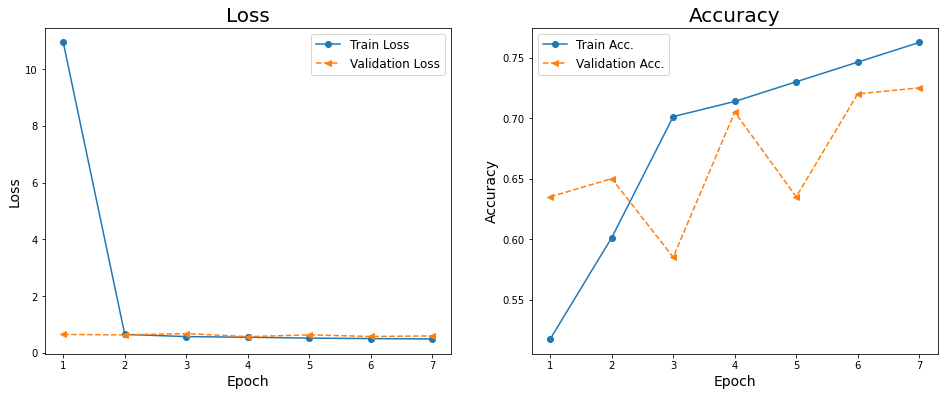

In [18]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
# print(x_arr)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

In [19]:
eval_train = model.evaluate(train_data_generator)
print(f'Train Accuracy: {eval_train[1]*100:.2f}%')
print()
eval_test = model.evaluate(test_data_generator)
print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

25/25 [==============================] - 2s 87ms/step - loss: 0.4891 - accuracy: 0.7550
Train Accuracy: 75.50%

7/7 [==============================] - 60s 10s/step - loss: 0.5529 - accuracy: 0.7050
Test Accuracy: 70.50%



In [20]:
y_true = test_data_generator.classes
y_pred = (model.predict(test_data_generator) > 0.5).astype('int32')
# y_pred

7/7 [==============================] - 1s 73ms/step


In [21]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,5))
conf_max = confusion_matrix(y_true, y_pred)
# sns.heatmap(conf_max, annot=True, fmt='d')

# plt.xlable('pred label')
# plt.ylabel('true label')
# plt.show()

ValueError: ignored

<Figure size 864x360 with 0 Axes>

In [ ]:
# test_data_generator

In [ ]:

# Transform logits to probabilities
pred_logits = model.predict(test_data_generator)
probabilities = tf.sigmoid(pred_logits)
probabilities = probabilities.numpy().flatten()*100
print(probabilities)

In [ ]:
# fig = plt.figure(figsize=(16,25))

# for j, example in enumerate(test_data_generator[:20]):
#     ax = fig.add_subplot(8,4, j+1)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.imshow(array_to_img(example))
#     if y_test[j]==0:
#         label='Non-IDC'
#     else:
#         label='IDC'
    
#     ax.text(
#         0.5, -0.15, 
#         'True Label: {:s}\nPr(IDC)={:.0f}%'.format(label, probabilities[j]), 
#         size=14, 
#         color='grey',
#         horizontalalignment='center',
#         verticalalignment='center', 
#         transform=ax.transAxes)
    
# plt.tight_layout()
# plt.show()

## Read training/test/validation images 


In [ ]:
def read_images(binary_class, folder):
  current_working_dir = os.getcwd()
  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path) 
  # if folder == 'Dataset/Train/':
  #   image_files_wo_path, image_files_w_path = image_files_wo_path[:200], image_files_w_path[:200]
  return image_files_wo_path, image_files_w_path    

In [ ]:
# ======================================================================== #
# ===================== Read Training Images ============================= #
# ======================================================================== #

train_class_1_wo_path, train_class_1_w_path = read_images('1', 'Dataset/Train/')
train_class_0_wo_path, train_class_0_w_path = read_images('0', 'Dataset/Train/')
train_full_wo_path = train_class_1_wo_path + train_class_0_wo_path
train_full_w_path = train_class_1_w_path + train_class_0_w_path

print(f'Size of Train Class 1 = {len(train_class_1_wo_path)} | {type(train_class_1_wo_path)}\nSample Images in Train Class 1:\n {train_class_1_wo_path[:2]}')
print(f'\nxSize of Train Class 0 = {len(train_class_0_wo_path)} | {type(train_class_0_wo_path)}\nSample Images in Train Class 0:\n {train_class_0_wo_path[:2]}')
print('\nTrain class_1 and class_0 combined:\n',train_full_wo_path[0], ',', train_full_wo_path[-1])
print('\nTrain class_1 with full path:\n',train_class_1_w_path[:2])

In [ ]:
# ======================================================================== #
# ===================== Read Test Images ================================= #
# ======================================================================== #

test_class_1_wo_path, test_class_1_w_path = read_images('1', 'Dataset/Test/')
test_class_0_wo_path, test_class_0_w_path = read_images('0', 'Dataset/Test/')
test_full_wo_path = test_class_1_wo_path + test_class_0_wo_path
test_full_w_path = test_class_1_w_path + test_class_0_w_path

print(f'Size of Test Class 1 = {len(test_class_1_wo_path)} | {type(test_class_1_wo_path)}\nSample Images in Test Class 1:\n {test_class_1_wo_path[:2]}')
print(f'\nSize of Test Class 0 = {len(test_class_0_wo_path)} | {type(test_class_0_wo_path)}\nSample Images in Test Class 0:\n {test_class_0_wo_path[:2]}')
print('\nTest class_1 and class_0 combined:\n',test_full_wo_path[0], ',', test_full_wo_path[-1])
print('\nTest class_1 with full path:\n',test_class_1_wo_path[:2])

In [ ]:
# ======================================================================== #
# ===================== Read Validation Images =========================== #
# ======================================================================== #

val_class_1_wo_path, val_class_1_w_path = read_images('1', 'Dataset/Validate/')
val_class_0_wo_path, val_class_0_w_path = read_images('0', 'Dataset/Validate/')
val_full_wo_path = val_class_1_wo_path + val_class_0_wo_path
val_full_w_path = val_class_1_w_path + val_class_0_w_path

print(f'Size of Validation Class 1 = {len(val_class_1_wo_path)} | {type(val_class_1_wo_path)}\nSample Images in Validation Class 1:\n {val_class_1_wo_path[:2]}')
print(f'\nSize of Validation Class 0 = {len(val_class_0_wo_path)} | {type(val_class_0_wo_path)}\nSample Images in Validation Class 0:\n {val_class_0_wo_path[:2]}')
print('\nValidation class_1 and class_0 combined:\n',val_full_wo_path[0], ',', val_full_wo_path[-1])
print('\nValidation class_1 with full path:\n',val_class_1_wo_path[:2])

## Check the number of train images in each class


In [ ]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count (Balanced) = ', class_1_size + class_0_size)
  return df_perc

check_class_size(train_class_1_wo_path, train_class_0_wo_path)

## Create dataframes of training/test/validation for each class

In [ ]:
def create_class_df(class_1_w_path, class_0_w_path): 
  image_list_w_path = [x for x in class_1_w_path]
  image_list_w_path.extend([x for x in class_0_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(class_1_w_path), ['Non_IDC']*len(class_0_w_path)]), columns=['class_str'])
  df_idc['class'] = np.where(df_idc.class_str == 'IDC', 1, 0)
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc

In [ ]:
# ======================================================================== #
# ===================== Create Train DF ================================== #
# ======================================================================== #
df_train_full = create_class_df(train_class_1_w_path, train_class_0_w_path)
training_sample_size = df_train_full.shape[0]
df_train_full

In [ ]:
# ======================================================================== #
# ===================== Create Test DF ================================== #
# ======================================================================== #
df_test_full = create_class_df(test_class_1_w_path, test_class_0_w_path)
df_test_full

In [ ]:
# ======================================================================== #
# ===================== Create Validation DF ============================= #
# ======================================================================== #
df_val_full = create_class_df(val_class_1_w_path, val_class_0_w_path)
df_val_full

## Image distribution in the training data set

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.countplot(df_train_full['class_str'], data=df_train_full)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.title('Number of Cases', fontsize=18)
plt.ylim(0,450)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width()/2., 
                p.get_height()), ha='center', va='center', size=15, xytext=(0,9),
               textcoords = 'offset points', fontsize=13)

## Display 6 train images for each class


In [ ]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  # images = []
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (224,224))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    ax.set_xticks([])       # remove xticks passing an empty array
    ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(train_class_1_w_path, 'Class 1: IDC')
display_images(train_class_0_w_path, 'Class 0: Non-IDC')

[Invasive ductal carcinoma (IDC) of the breast](https://www.mypathologyreport.ca/breast-invasive-ductal-carcinoma/)

In [ ]:
# plt.imshow(cv.resize(io.imread('9383_idx5_x1951_y951_class1.png'), (80,80)))

## Store actual color images as a vector


In [ ]:
# from skimage import color
def store_actual_images_to_grayscale(class_1_w_path, class_0_w_path):
  # read and store actual images (not the image paths) into the respective variable as a single vector then pass these to the model below
  image_pixels_class1 = [io.imread(img) for img in class_1_w_path]
  image_pixels_class0 = [io.imread(img) for img in class_0_w_path]
  full_image_pixels = np.asarray(image_pixels_class1 + image_pixels_class1)   # => (#samples, width, height)
  return image_pixels_class1, image_pixels_class0, full_image_pixels

In [ ]:
# ======================================================================== #
# ===================== Store Train Images =============================== #
# ======================================================================== #
train_img_class1, train_img_class0, train_full_img = store_actual_images_to_grayscale(train_class_1_w_path, train_class_0_w_path)

print('Shape of each train image: ', train_img_class1[0].shape)
print('\nTotal number of images = ', len(train_full_img))
print('Number of class 1 images = ', len(train_img_class1))
print('Number of class 0 images = ', len(train_img_class0))
print('train_full_img = ', train_full_img.shape)

In [ ]:
# ======================================================================== #
# ===================== Store Test Images ================================ #
# ======================================================================== #
test_img_class1, test_img_class0, test_full_img = store_actual_images_to_grayscale(test_class_1_w_path, test_class_0_w_path)

print('Shape of each test image: ', test_img_class1[0].shape)
print('\nTotal number of images = ', len(test_full_img))
print('Number of class 1 images = ', len(test_img_class1))
print('Number of class 0 images = ', len(test_img_class0))
print('test_full_img = ', test_full_img.shape)

In [ ]:
# ======================================================================== #
# ===================== Store Validation Images ========================== #
# ======================================================================== #
val_img_class1, val_img_class0, val_full_img = store_actual_images_to_grayscale(val_class_1_w_path, val_class_0_w_path)

print('Shape of each validataion image: ', val_img_class1[0].shape)
print('\nTotal number of images = ', len(val_full_img))
print('Number of class 1 images = ', len(val_img_class1))
print('Number of class 0 images = ', len(val_img_class0))
print('val_full_img = ', val_full_img.shape)

## Image augmentation techniques on a training image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import util
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma

fig = plt.figure(figsize=(22,9))

# original image
original = io.imread(train_class_1_w_path[3])

# resized image
resized_img = cv.resize(train_img_class1[3], (120,120))

# pull an original image as is
ax = fig.add_subplot(2,5,1)
ax.imshow(original)
# ax.axis('off')
ax.set_title('Original: 50 x 50', size=14)

# resize an original image to 120 x 120
ax = fig.add_subplot(2,5,2)
ax.imshow(resized_img)                         
# ax.axis('off')
ax.set_title('Step 1: Resize 120 x 120', size=14)

# rotate an original image 90 degrees
ax = fig.add_subplot(2,5,3)
rot90_img = tf.image.rot90(resized_img, k=1)
ax.imshow(rot90_img)
# ax.axis('off')
ax.set_title('Step 2: Rotate 90', size=14)

# invert the resized image
ax = fig.add_subplot(2,5,4)
inverted_img = util.invert(resized_img)
plt.imshow(inverted_img);
# ax.axis('off')
ax.set_title('Step 3: Invert', size=14)

# adjust brightness of the resized image
ax = fig.add_subplot(2,5,5)
bright_img = tf.image.adjust_brightness(resized_img, 0.3)
plt.imshow(bright_img);
# ax.axis('off')
ax.set_title('Step 4: Brightness', size=14)

# adjust contrast of the brightened image
ax = fig.add_subplot(2,5,6)
contrast_img = tf.image.adjust_contrast(bright_img, contrast_factor=3)
plt.imshow(contrast_img);
# ax.axis('off')
ax.set_title('Step 5: Contrast', size=14)

# flip left right of the contrasted image
ax = fig.add_subplot(2,5,7)
flipped_img = tf.image.flip_left_right(contrast_img)
plt.imshow(flipped_img);
# ax.axis('off')
ax.set_title('Step 6: Flip Left Right', size=14)

# random noise: function to add random noise of various types to a floating-point image
ax = fig.add_subplot(2,5,8)
sigma = 0.355
noisy_img = random_noise(resized_img, var=sigma**2)
plt.imshow(noisy_img);
# ax.axis('off')
ax.set_title('Step 7: Random Noise', size=14)

# denoise_tv_chambolle: perform total-variation denoising on n-dimentional images
ax = fig.add_subplot(2,5,9)
dchambolle_img = denoise_tv_chambolle(resized_img, weight=0.1, multichannel=True)
plt.imshow(dchambolle_img);
# ax.axis('off')
ax.set_title('Step 8: Denoise TV Chambolle', size=14)

# denoise_wavelet:  perform wavelet denoising on an image
ax = fig.add_subplot(2,5,10)
dwavelet_img = denoise_wavelet(resized_img, multichannel=True)
plt.imshow(dwavelet_img);
# ax.axis('off')
ax.set_title('Step 9: Denoise Wavelet', size=14);

## Specify image data (X) and labels (y)

In [ ]:
def define_X_and_y(data_pixels, df_data):
  X = data_pixels
  y = np.array(df_data['class']).flatten()   # no need to flatten here but maybe later on before I feed this to the model 
  return X, y

In [ ]:
X_train, y_train = define_X_and_y(train_full_img, df_train_full)
X_test, y_test = define_X_and_y(test_full_img, df_test_full)
X_val, y_val = define_X_and_y(val_full_img, df_val_full)

print('X_train: ', X_train.shape, type(X_train))
print('X_test: ',X_test.shape, type(X_test))
print('X_val: ',X_val.shape, type(X_val))

## Randomize images (X) and labels (y) 


In [ ]:
# print(X_train[0],'\n')
def shuffle_X_and_y(X, y):
  tf.random.set_seed(1234)
  np.random.seed(1234)
  shuffle = np.random.permutation(np.arange(X_train.shape[0]))      # randomize 
  return X_train[shuffle], y_train[shuffle]

In [ ]:
X_train, y_train = shuffle_X_and_y(X_train, y_train)
X_test, y_test = shuffle_X_and_y(X_test, y_test)
X_val, y_val = shuffle_X_and_y(X_val, y_val)

print('y_val_shuffled:\n', y_val)
print('\ny_test_shuffled:\n', y_test)
print('\ny_train: total number of labels = ', len(y_train), type(y_train) ,'\n', y_train[:5], y_train[-5:])
print('\nX_train: total number of images = ', len(X_train), type(X_train), '\n', X_train[0])

## Resize images from (50, 50) to (80, 80) on X

In [ ]:
image_size = (80,80)
X_train = tf.image.resize(X_train, size=image_size)
X_test = tf.image.resize(X_test, size=image_size)
X_val = tf.image.resize(X_val, size=image_size)
print(type(X_train), X_train.shape)
print('\nX_train[0]:\n',X_train[0])


## Convert to gray scale and normalize images
Rescale images to [0,1]

In [ ]:
X_train = tf.image.rgb_to_grayscale(X_train)/255.0
X_test = tf.image.rgb_to_grayscale(X_test)/255.0
X_val = tf.image.rgb_to_grayscale(X_val)/255.0
print(X_train.shape)
# print(X_train[0])

## Image augmentation on training images
- Adjust brightness
- Adjust contrast
- Flip left and right
- Rotate 90 degrees

In [ ]:
brightness_delta = 0.3
contrast_factor = 3
rot_degree = 1               # rotate mapping => key:val = angle:k = {90:1, 180:2, 270:3}

# add a set of augmented images to X_train_norm rather than overwrite the existing ones
X_train_bright = tf.image.adjust_brightness(X_train, delta=brightness_delta)
X_train_contrast = tf.image.adjust_contrast(X_train, contrast_factor=contrast_factor)
X_train_flip = tf.image.random_flip_left_right(X_train)
X_train_rot90 = tf.image.rot90(X_train, k=rot_degree)            
# X_train_invert = util.invert(X_train)
# X_train_noise = random_noise(X_train, var=0.355**2)   # sigma = 0.355
# dchambolle_img = denoise_tv_chambolle(X_train, weight=0.1, multichannel=True)
# X_train_dwavelet = denoise_wavelet(X_train, multichannel=True)

## Merge original training images with the augmented images

In [ ]:
# concatenate X_train_final with augmented X_train
X_train = tf.concat([X_train, 
                    X_train_bright, 
                    X_train_contrast, 
                    X_train_flip,
                    X_train_rot90], axis=0)
print('X_train with augmentation: ', X_train.shape)

# concatenate y_train (the label is preserved)
y_train = y_train
y_train_bright, y_train_contrast, y_train_flip, y_train_rot90 = y_train, y_train, y_train, y_train
y_train = tf.concat([y_train, 
                    y_train_bright, 
                    y_train_contrast, 
                    y_train_flip,
                    y_train_rot90], axis=0)
print('y_train_bright: ', y_train_bright.shape)
print('y_train with augmentation: ', y_train.shape)

## Shuffle X_train and y_train
Shuffle two tensors in the same order

In [ ]:
print(tf.shape(X_train))
shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
X_train = tf.gather(X_train, shuffle)
y_train = tf.gather(y_train, shuffle).numpy()  # also transforms y_train to numpy array

In [ ]:
print(X_train[0][1][1])
print(y_train[:100])

## Display the first 10 train and validation examples with the label of each example as the title

In [ ]:
print('Print training data examples:')
nrows, ncols = 1,5 
f, axs = plt.subplots(nrows, ncols, figsize=(19,15))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

In [ ]:
# print validation data
print('Print validation data examples:')
nrows, ncols = 1,5 
f, axs = plt.subplots(nrows, ncols, figsize=(19,15))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

## CNN Model using Tensorflow Keras API<br>
1) Build model<br>
2) Compile model<br>
3) Fit model

In [ ]:
input_shape = (80,80,1)
filters_1 = 32
# filters_2 = 32
# filters_3 = 64
kernel_size = (3,3)
pool_size = (2,2)
strides = (1, 1)
fully_connected_layer_units = 100
dropout_rate = 0.3

# 1)  Build model
def build_model(activation='tanh',
                optimizer='SGD',
                learning_rate=0.01):
  
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Building the CNN
  model = Sequential()      # initialize the model using Sequential(), which indicates our network will be stacked with different layers

  # Define activation function
  if activation.lower() == 'leakyrelu':
    activation = tf.keras.layers.LeakyReLU(alpha=0.3)    # alpha = Float >= 0. Negative slope coefficient. Default to 0.3
  
  # Add the convolutional layers
  model.add(Conv2D(filters=filters_1, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))                  # 1st convolutional layer
  model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 1st Pooling
  # model.add(Conv2D(filters=filters_2, kernel_size=kernel_size, activation=activation, padding='same'))                                           # 2nd convolutional layer
  # model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 2nd Pooling
  # model.add(Conv2D(filters=filters_3, kernel_size=kernel_size, activation=activation, padding='same'))                                           # 3rd convolutional layer
  # model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 3rd Pooling

  # Flatten the dataset to feed into a fully connected layer
  model.add(Flatten())    

  # Fully connected layer
  model.add(Dense(units=fully_connected_layer_units,                 # This can be adjusted (a hyper param)
                  activation=activation))                            # For the first layer: the number of units or neurons

  # Dropout layer
  # model.add(Dropout(rate=dropout_rate))
  
  # Output layer
  model.add(Dense(
        units=1,                                 # binary output dimension (only one neuron)
        # use_bias=True,                           # Alternative: use_bias=False
        activation=None))                     # activation='sigmoid'

  if optimizer.lower() == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer.lower() == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)   

# 2) Compile Model
  model.compile(loss=BinaryCrossentropy(from_logits=True),             # for a binary classification
                optimizer=optimizer,                    # used to change the attributes of a neural network such as weights and learning rate to reduce the losses.
                metrics=['accuracy'])            
  print(f'CNN Model:\nActivation = {activation}\nOptimizer = {optimizer}\nlearning_rate = {learning_rate}\n')
  return model

In [ ]:
learning_rate = 0.1
activation='relu'
optimizer='sgd'

model = build_model(activation=activation,              # relu, leakyrelu, tanh, sigmoid
                optimizer=optimizer,                    # adam, [SGD]        
                learning_rate=learning_rate)        # 0.1, 0.01, 0.001
model.summary()

### 3) Fit Model

In [ ]:
num_epochs = 20
batch_size = 16

print(f'Hyperparameters: \
      \n\ttraining_sample_size = {training_sample_size} \
      \n\tnum_epochs = {num_epochs} \
      \n\tbatch_size = {batch_size} \
      \n\timage_size = {image_size} \
      \n\tinput_shape = {input_shape} \
      \n\tfilters_1 = {filters_1} \
      \n\tfully_connected_layer_units = {fully_connected_layer_units} \
      \n\tkernel_size = {kernel_size} \
      \n\tpool_size = {pool_size} \
      \n\tstrides = {strides} \
      \n\tlearning_rate = {learning_rate} \
      \n\tactivation = {activation} \
      \n\toptimizer = {optimizer} \
      \n\nImage Agumentation Params: \
      \n\tbrightness_delta = {brightness_delta} \
      \n\tcontrast_factor = {contrast_factor} \
      \n\trot_degree = {rot_degree}\n')


tf.random.set_seed(1234)
np.random.seed(1234)

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data = (X_val, y_val))

## Plot loss and accuracy for training and validation sets

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
# print(x_arr)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

## Model Evaluation

In [ ]:
eval_test = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

eval_train = model.evaluate(X_train, y_train)
print(f'Train Accuracy: {eval_train[1]*100:.2f}%')

## Model Prediction

In [ ]:
eval_test = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

eval_train = model.evaluate(X_train, y_train)
print(f'Train Accuracy: {eval_train[1]*100:.2f}%')

# Transform logits to probabilities
pred_logits = model.predict(X_test)
probabilities = tf.sigmoid(pred_logits)
probabilities = probabilities.numpy().flatten()*100
# print(probabilities)

## Plot Test vs. Predicted

In [ ]:
fig = plt.figure(figsize=(16,25))

for j, example in enumerate(X_test[:20]):
    ax = fig.add_subplot(8,4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        label='Non-IDC'
    else:
        label='IDC'
    
    ax.text(
        0.5, -0.15, 
        'True Label: {:s}\nPr(IDC)={:.0f}%'.format(label, probabilities[j]), 
        size=14, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

# 2. Prediction the most common area that may be detected IDC using patch locations



## Extract features from file names

In [ ]:
# def extract_features(file_list): 
#   features = []
#   for file in file_list:
#     str_feat = re.findall(r'\d+', file)
#     int_feat = [int(feat) for feat in str_feat]
#     features.append(int_feat)
#   df_feat = pd.DataFrame(features, columns=['patient_id', 'd', 'x_coord', 'y_coord', 'class']).drop('d', axis=1)
#   df_feat['patch_coord'] = list(zip(df_feat.x_coord, df_feat.y_coord))
#   return df_feat[['patient_id','x_coord', 'y_coord', 'patch_coord','class']]


# df_features = extract_features(full_data_wo_path)
# print(df_features.shape)
# display(df_features.head().append(df_features.tail()))

In [ ]:
# df_features.info()

## Randomize data 
: As we may use SGD for training, we will randomize sample of the data for each batch so that the gradient computed is representative.

In [ ]:
# indexes = np.arange(df_features.shape[0])
# print('indexes:', indexes)

# np.random.seed(0)    # get the same results each time    ??????
# shuffled_indexes = np.random.permutation(indexes)
# print('shuffled indexes:', shuffled_indexes, '\n')

# # change the ordering of the original df_features using .reindex()
# df_features = df_features.reindex(shuffled_indexes)
# display(df_features)

## Train/Test split (80/20) & Feature Selection

In [ ]:
# split_boundary = int(df_features.shape[0]*.8)

# train = pd.DataFrame(df_features.iloc[:split_boundary, 3:])
# test = pd.DataFrame(df_features.iloc[split_boundary:, 3:])

# print('Train Shape: ', train.shape, '\n', train.head(3))
# print('\nTest Shape: ', test.shape, '\n', test.head(3))